In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [2]:
def ts_to_str(ts):
    try:
        dt = datetime.fromtimestamp(ts)
    except OSError:
        dt = datetime.fromtimestamp(ts/1000)
    return str(dt.strftime("%d %b %Y %H:%M %S"))

def translate_ts(ts,translation,interval):
    if interval=='s':
        multiple = 1
    elif interval=='m':
        multiple = 60
    elif interval=='h':
        multiple = 60*60
    elif interval=='d':
        multiple = 60*60*24
    return ts+(translation*multiple)

def str_to_ts(date_str):
    return time.mktime(datetime.strptime(date_str, "%d %b %Y %H:%M %S").timetuple())

#Test timestamps and string dates convert accurately
ts_to_str(translate_ts(str_to_ts('09 May 2028 01:00 00'),-1,'d'))

'08 May 2028 01:00 00'

In [3]:
#Set parameters for Binance API
#Use API keys from Binance account
api_key='***'
secret_key='***'

url = 'https://api.binance.com/api/v3/klines'

headers={'X-MBX-APIKEY': api_key}

#Set asset price being checked, in this case Ethereum price in GBP
currency = 'ETHGBP'

In [4]:
rn = int(time.time())

r = requests.get(url=url, headers=headers, params={"symbol":currency
                                                   ,"interval":"1d"
                                                   #,"startDate":str_to_ts('21 Aug 2022 00:00 00')
                                                   #,"endDate":str_to_ts('22 Aug 2022 00:00 00')
                                                   ,"limit":1000
                                                  })

In [5]:
prices = np.array(r.json(),dtype=float)
dates = list(map(ts_to_str,prices[:,0]))
prices = pd.DataFrame(prices[:,1:5],index=dates,columns=['open','high','low','close'])

prices['change_open'] = np.array([np.nan]+[prices['open'].iloc[i]/prices['open'].iloc[i-1] for i in range(1,len(prices))])-1

#Check API request returned valid data
prices

,open,high,low,close,change_open
19 Jun 2020 01:00 00,184.44,187.76,184.44,184.93,NaN
20 Jun 2020 01:00 00,185.04,186.31,182.00,185.33,0.003253
21 Jun 2020 01:00 00,186.14,186.54,184.04,184.10,0.005945
22 Jun 2020 01:00 00,184.71,198.47,184.61,194.50,-0.007682
23 Jun 2020 01:00 00,195.41,196.00,193.64,194.15,0.057929
...,...,...,...,...,...
15 Oct 2022 01:00 00,1160.48,1164.49,1131.62,1140.72,0.018304
16 Oct 2022 01:00 00,1141.60,1172.01,1141.60,1161.71,-0.016269
17 Oct 2022 01:00 00,1161.48,1178.25,1153.65,1173.70,0.017414
18 Oct 2022 01:00 00,1174.07,1180.91,1138.00,1154.81,0.010840


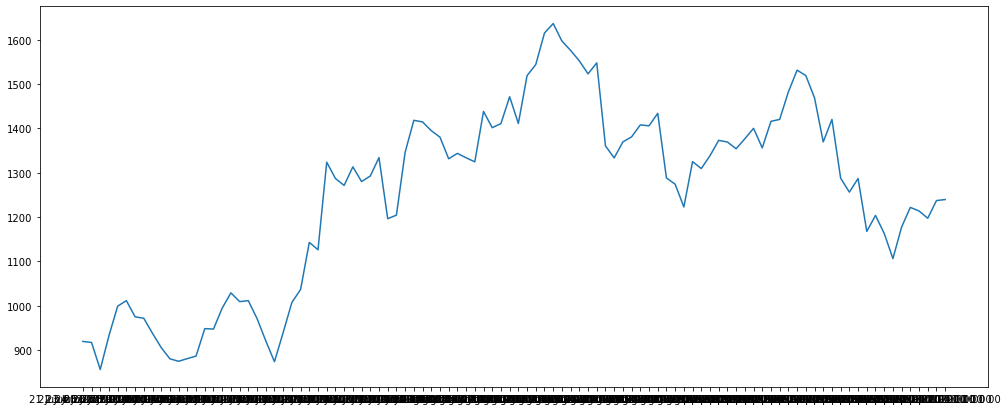

In [38]:
#Show the movement of price throughout the timeframe of the data
plt.rcParams['figure.figsize'] = [17, 7]
plt.plot(prices['open'].iloc[-100:])
plt.show()

In [39]:
#Create columns in data frame for moving average of asset price for windows of 2 to 100
moving_avg_max = 100

cols=[]
for window in range(2,moving_avg_max+1):
    cols.append([np.mean(prices['open'].iloc[i-window+1:i+1]) for i in range(len(prices))])
    
cols = pd.DataFrame(np.transpose(np.array(cols)),index=dates)
data = pd.concat([prices,cols],axis=1)
data.rename(columns={i:'moving_avg_'+str(i+2) for i in range(moving_avg_max-1)},inplace=True)
data

,open,high,low,close,change_open,moving_avg_2,moving_avg_3,moving_avg_4,moving_avg_5,moving_avg_6,...,moving_avg_91,moving_avg_92,moving_avg_93,moving_avg_94,moving_avg_95,moving_avg_96,moving_avg_97,moving_avg_98,moving_avg_99,moving_avg_100
19 Jun 2020 01:00 00,184.44,187.76,184.44,184.93,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20 Jun 2020 01:00 00,185.04,186.31,182.00,185.33,0.003253,184.740,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21 Jun 2020 01:00 00,186.14,186.54,184.04,184.10,0.005945,185.590,185.206667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22 Jun 2020 01:00 00,184.71,198.47,184.61,194.50,-0.007682,185.425,185.296667,185.0825,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23 Jun 2020 01:00 00,195.41,196.00,193.64,194.15,0.057929,190.060,188.753333,187.8250,187.148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24 Sep 2022 01:00 00,1221.80,1241.36,1203.56,1213.33,0.037525,1199.705,1168.593333,1167.2375,1174.514,1173.375000,...,1269.147582,1266.211848,1262.624946,1258.301809,1254.711579,1251.220833,1247.826289,1243.383469,1239.798485,1236.0361
25 Sep 2022 01:00 00,1213.70,1230.87,1170.00,1196.99,-0.006630,1217.750,1204.370000,1179.8700,1176.530,1181.045000,...,1271.369231,1268.544891,1265.647204,1262.104468,1257.832316,1254.284375,1250.834021,1247.478061,1243.083636,1239.5375
26 Sep 2022 01:00 00,1197.31,1247.29,1192.49,1237.31,-0.013504,1205.505,1210.936667,1202.6050,1183.358,1179.993333,...,1273.811319,1270.564239,1267.778925,1264.920213,1261.422421,1257.201875,1253.697010,1250.287857,1246.971313,1242.6259
27 Sep 2022 01:00 00,1237.23,1293.50,1221.01,1240.50,0.033341,1217.270,1216.080000,1217.5100,1209.530,1192.336667,...,1276.728791,1273.413696,1270.205806,1267.453936,1264.628737,1261.170417,1256.995979,1253.528980,1250.155960,1246.8739


In [40]:
#Identify buy and sell signals in data based on short window and long window parameters
def buy_sell_signal(short_window, long_window):
    short_window_col = data['moving_avg_'+str(short_window)]
    long_window_col = data['moving_avg_'+str(long_window)]
    signal = np.zeros(len(data))
    signal[:long_window] = np.nan
    for i in range(long_window,len(data)):
        if short_window_col[i-1] <= long_window_col[i-1] and short_window_col[i] > long_window_col[i]:
            signal[i] = 1
        if short_window_col[i-1] >= long_window_col[i-1] and short_window_col[i] < long_window_col[i]:
            signal[i] = -1
    return signal

In [41]:
#Create target data based on whether the price will move up or down the next day
buy_true = np.where(data['change_open'][111:]>0)[0]+110
sell_true = np.where(data['change_open'][111:]<0)[0]+110

#Compare moving average crossovers with target data
scores = []
for long_window in range(3,50):
    for short_window in range(2,long_window):
        signal = buy_sell_signal(short_window, long_window)
        buy_predicted = np.where(signal[110:]==1)[0]+110
        sell_predicted = np.where(signal[110:]==-1)[0]+110
        tb = np.intersect1d(buy_true,buy_predicted)
        fb = [i for i in buy_predicted if i not in buy_true]
        ts = np.intersect1d(sell_true,sell_predicted)
        fs = [i for i in sell_predicted if i not in sell_true]
        scores.append([long_window,short_window,len(buy_predicted),len(tb),len(fb),len(sell_predicted),len(ts),len(fs)])

#Collect results in data frame
results = pd.DataFrame(scores,columns=['long window','short window','b','tb','fb','s','ts','fs'])
results['tbr'] = results['tb']/results['b']
results['tsr'] = results['ts']/results['s']
results

,long window,short window,b,tb,fb,s,ts,fs,tbr,tsr
0,3,2,139,66,73,139,50,89,0.474820,0.359712
1,4,2,95,49,46,95,37,58,0.515789,0.389474
2,4,3,113,58,55,113,54,59,0.513274,0.477876
3,5,2,78,36,42,78,34,44,0.461538,0.435897
4,5,3,78,39,39,78,38,40,0.500000,0.487179
...,...,...,...,...,...,...,...,...,...,...
1123,49,44,8,5,3,8,3,5,0.625000,0.375000
1124,49,45,9,6,3,9,7,2,0.666667,0.777778
1125,49,46,11,5,6,11,6,5,0.454545,0.545455
1126,49,47,11,3,8,11,5,6,0.272727,0.454545


In [42]:
#Results sorted by the 'true buy rate' - proportion of buy signals which are followed by a price increase the next day
results.sort_values('tbr',ascending=False)

,long window,short window,b,tb,fb,s,ts,fs,tbr,tsr
886,44,27,7,7,0,7,3,4,1.000000,0.428571
586,36,27,10,10,0,10,1,9,1.000000,0.100000
892,44,33,8,8,0,8,3,5,1.000000,0.375000
587,36,28,9,8,1,9,1,8,0.888889,0.111111
449,32,16,8,7,1,8,5,3,0.875000,0.625000
...,...,...,...,...,...,...,...,...,...,...
332,28,9,11,2,9,11,5,6,0.181818,0.454545
722,40,21,7,1,6,7,4,3,0.142857,0.571429
685,39,21,7,1,6,7,5,2,0.142857,0.714286
801,42,23,7,1,6,7,1,6,0.142857,0.142857


In [43]:
#Results sorted by the 'true sell rate' - proportion of sell signals which are followed by a price decrease the next day
results.sort_values('tsr',ascending=False)

,long window,short window,b,tb,fb,s,ts,fs,tbr,tsr
906,45,5,11,6,5,11,10,1,0.545455,0.909091
986,46,42,9,3,6,9,8,1,0.333333,0.888889
1119,49,40,8,4,4,8,7,1,0.500000,0.875000
1107,49,28,7,6,1,7,6,1,0.857143,0.857143
1062,48,29,7,4,3,7,6,1,0.571429,0.857143
...,...,...,...,...,...,...,...,...,...,...
523,34,29,11,6,5,10,1,9,0.545455,0.100000
586,36,27,10,10,0,10,1,9,1.000000,0.100000
391,30,15,10,5,5,10,1,9,0.500000,0.100000
1105,49,26,7,5,2,7,0,7,0.714286,0.000000


In [47]:
#Check if the model with the most accurate buy signal has a signal for the next day
buy_sell_signal(27,36)[-1]

0.0

In [48]:
#Check if the model with the most accurate sell signal has a signal for the next day
buy_sell_signal(5,45)[-1]

0.0